<a href="https://colab.research.google.com/github/Zinnenlauf/github-slideshow/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning week - Day 3 - Exercise 3: Transfer Learning

This notebook is dedicated to **transfer learning** which corresponds to using an existing model that has been already trained on a particular task, and fine-tuning it for a different task.

To that end, we will use the [VGG-16 Neural Network](https://neurohive.io/en/popular-networks/vgg16/), a well-known architecture that has been trained on ImageNet which is a very large database of images of different categories.

The idea is that we will load the existing VGG16 network, remote the last fully connected layers, replace them by new connected layers whose weights are randomly set, and train these last layers on a specific classification task - here, separate types of flower. The underlying idea is that the first convolutional layers of VGG-16, that has already been trained, corresponds to filters that are able to extract meaning features from images.

# Google Colab

 In the following, the computations are computationally heavy and may be too long on your computer. For this reason, we will work in a new environment: **Google Colab** which provides free access to GPU that accelerate the computational time. 

To do so, you have to :
- Open Google Colab [here](https://colab.research.google.com/)
- Import a Notebook and select this file, the one you are currently reading.
- Once open, you a running a similar Notebook but in Google Colab.
- Change the runtime type to GPU - default is CPU.

# Data loading & Preprocessing

You first have to download the [data here](https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip) and add them to your Google Drive in a folder called `Deep_learning_data`. 

Then, run the following code. It will ask you to go to a given webpage where you copy the link and past it in the Colab form that will appear:

Now, Google Colab has access to your Google Drive. You can therefore load the data you just added to your drive. 

❓ **Question** ❓ Use the following code to load your data. Be patient, it can take several minutes to load.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tqdm import tqdm

import numpy as np
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical

def load_flowers_data():
    data_path = '/content/drive/My Drive/Deep_learning_data/flowers'
    classes = {'daisy':0, 'dandelion':1, 'rose':2}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes


X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data()

100%|██████████| 299/299 [00:01<00:00, 188.90it/s]


First things first, let's start by some preprocessing

❓ **Question** ❓ First check that all your images have the same size. How many colors do these images have?

In [3]:
print(f"X_train - {X_train.shape}")
print(f"X_val - {X_val.shape}")
print(f"X_test - {X_val.shape}")

X_train - (571, 256, 256, 3)
X_val - (179, 256, 256, 3)
X_test - (179, 256, 256, 3)


In [4]:
print(f"y_train - {y_train.shape}")

y_train - (571, 3)


In [5]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

❓ **Question** ❓ Resize your images

In [6]:
import tensorflow as tf
X_train_resize = tf.image.resize(X_train, [224,224])

In [7]:
X_train_resize.shape

TensorShape([571, 224, 224, 3])

❓ **Question** ❓ Plot some images with the `imshow` function of matplotlib. If you obtained an ugly image, figure out why and correct the problem !

In [8]:
X_train_resize = X_train / 255
X_test_resize = X_test / 255
X_val_resize = X_val / 255

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

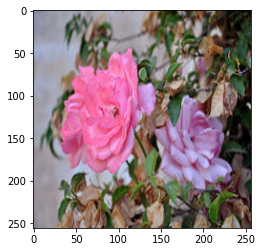

In [10]:
plt.imshow(X_train[1])

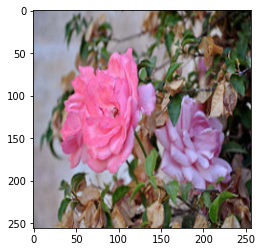

In [11]:
plt.imshow(X_train_resize[1])

# The model

Let's now build our model. 

❓ **Question** ❓ Write a first function `load_model()` that loads the pretrained VGG-16 model from `tensorflow.keras.applications.vgg16`. Especially, look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16) to load the model where:
- the `weights` have been learnt on `imagenet`
- the `input_shape` corresponds to the input shape of any of your images (which all should have the same shape as see previously)
- the `include_top` argument is set to `False` in order not to load the fully-connected layers of the VGG-16 

❗ **Remark** ❗ Do not change the default value of the other arguments

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16(weights='imagenet', input_shape=(256, 256, 3),
        include_top = False) # pooling=None, classes=1000, classifier_activation='softmax'
  
    return model

❓ **Question** ❓ Look at the architecture of the model thanks to the summary method

In [35]:
model = load_model()

In [36]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Impressive, right? Two things to notice:
- It ends with convolution. The flattening of the output and the fully connected layers are not here yet! We will add them
- There are more than 14.000.000 parameters, which is a lot. We could fine-tune them, meaning still updates them in the model algorithm, but it will take a lot of time, therefore we will fix them so they are not trainable. And only the last layers (that we will add) will be trained and updates

❓ **Question** ❓ Write a function that takes the previous model as input, and does what we just described:
- set the first layers to be not-trainable, by applying `model.trainable = False`
- adding new layers that by default will be trainable.

To do the second part (adding new layers), we will use another way to define the model (instead of `model.sequential()`). Look at the following code and try to apply it in your scenario:

```
base_model = load_model()
dense_layer = layers.Dense(SOME_NUMBER_1, activation='relu')
prediction_layer = layers.Dense(SOME_NUMBER_2, activation='APPROPRIATE_ACTIVATION')

model = tf.keras.Sequential([
  base_model,
  dense_layer,
  prediction_layer
])

```

❗ **Remark** ❗ Let's consider a dense layer with 500 neurons ; on the other hand, the prediction layer should be related to this specific task, so just replace `SOME_NUMBER_2` and `APPROPRIATE_ACTIVATION` with the correct values. 


❗ **Remark** ❗ Do not forget to Flatten the convoluted outputs first, before the fully connected layers ;)

In [37]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [38]:
y_train.shape

(571, 3)

In [39]:
from tensorflow.keras import layers
from tensorflow.keras import models


def update_model():
    
    base_model = load_model()
    # Set the first layers to be untrainable
    base_model.trainable = False
    
    # Add layers to the model
    flattened = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')
 
    model = tf.keras.Sequential([
    base_model,
    flattened,
    dense_layer,
    prediction_layer
    ])
    
    return model

❓ **Question** ❓ Now look at the layers and parameters of your model. Note that there is a distinction, at the end, between the trainable and non-trainable parameters

In [40]:
model_new = update_model()
model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               16384500  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1503      
Total params: 31,100,691
Trainable params: 16,386,003
Non-trainable params: 14,714,688
_________________________________________________________________


❓ **Question** ❓ Write a function to compile your model - we advise Adam with `learning_rate=1e-4`. 

In [41]:
from tensorflow.keras import optimizers

def compile_model(model):
  adam_opt = optimizers.Adam(learning_rate=0.1e-4)
  model.compile(loss='categorical_crossentropy',
                optimizer=adam_opt,
                metrics=['accuracy'])
  
  return model
  

model_compile = compile_model(model_new)

❓ **Question** ❓ Write an overall function that :
- load the model
- update the layers
- compiles it

In [42]:
def build_model():
    
    model_updated = update_model()
    model_compiled = compile_model(model_updated)

    return model_compiled

In [43]:
model = build_model()

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               16384500  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1503      
Total params: 31,100,691
Trainable params: 16,386,003
Non-trainable params: 14,714,688
_________________________________________________________________


# Back to the data

The VGG16 model was trained on images which were preprocessed in a specific way. 

❓ **Question** ❓ Apply this processing to the images here using the method `preprocess_input` that you can import from `tensorflow.keras.applications.vgg16`.

In [45]:
preprocess_input?

In [61]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x_train_pre = preprocess_input(X_train)
x_test_pre = preprocess_input(X_test)
x_val_pre = preprocess_input(X_val)


In [76]:
y_val.shape

(179, 3)

In [62]:
X_train_resize.shape

(571, 256, 256, 3)

In [63]:
x_train_pre.shape

(571, 256, 256, 3)

In [64]:
y_train.shape

(571, 3)

In [65]:
x_test_pre.shape

(149, 256, 256, 3)

In [66]:
x_val_pre.shape

(179, 256, 256, 3)

In [74]:
y_val.shape

(179, 3)

# Run the model

❓ **Question** ❓ Now estimate the model, with an early stopping criterion on the validation accuracy - here, the validation data are provided, therefore use `validation_data` instead of `validation_split`.

❗ **Remark** ❗ Store the results in a `history` variable

In [67]:
x_val_pre.shape

(179, 256, 256, 3)

In [68]:
y_val.shape

(179, 3)

In [69]:
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=5, monitor = "val_acc", restore_best_weights = True, min_delta=1e-2)

history = model.fit(x_train_pre, y_train, 
          epochs=15, 
          batch_size=32, 
          verbose=1,
          validation_data=[x_val_pre, y_val],
          callbacks=[es])

Epoch 1/15
18/18 [==============================] - 3s 162ms/step - loss: 3.1629 - accuracy: 0.7268 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
18/18 [==============================] - 3s 154ms/step - loss: 0.1653 - accuracy: 0.9772 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/15
18/18 [==============================] - 3s 155ms/step - loss: 0.0138 - accuracy: 0.9965 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/15
18/18 [==============================] - 3s 156ms/step - loss: 6.9617e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/15
18/18 [==============================] - 3s 158ms/step - loss: 7.9188e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/15
18/18 [==============================] - 3s 158ms/step - loss: 6.6864e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/15
18/18 [==============================] - 3s 159ms/step - loss: 6.1846e-06 - a

# YOUR CODE HERE

❓ **Question** ❓ Plot the accuracy for the test and validation set.

In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

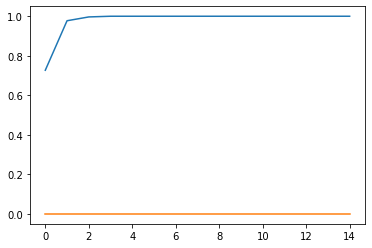

In [71]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

❓ **Question** ❓ Evaluate the model accuracy on the test set. What is the chance level on this classification task (i.e. accuracy of a random classifier).

In [73]:
model.evaluate(X_test_resize, y_test)

5/5 [==============================] - 2s 319ms/step - loss: 1.1512 - accuracy: 0.3490


[1.151212215423584, 0.34899330139160156]

# Data augmentation

The next question are a less guided but really on what you did in the previous exercise - don't hesitate to come back to what you have done.

❓ **Question** ❓ Use some data augmentation techniques for this task - you can store the fitting in a `history_data_aug` variable that you can plot. Do you see an improvement ? Don't forget to evaluate it on the test set

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.),
    zoom_range=(0.8, 1.2),
    rescale=1./255.) 

datagen.fit(x_train_pre)

In [79]:
train_flow = datagen.flow(x_train_pre, y_train, batch_size=16)

In [82]:
val_flow = datagen.flow(x_val_pre, y_val, batch_size=16)

# Advanced [Optional]

You can here try to improve the model test accuracy. To do that, here are some options you can consider

1) Is my model overfitting ? If yes, you can try  more data augmentation. If no, try a more complex model (unlikely the case here)

2) Perform precise grid search on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

3) Change the base model to more modern one (resnet, efficient nets) available in the keras library

4) Curate the data: maintaining a sane data set is one of the keys to success.

5) Obtain more data


❗ **Remark** ❗ Note also that it is good practice to perform a real cross-validation. You can also try to do that here to be sure of your results.